# Capstone 2 Springboard Pre-processing and Training Data Development

Data Science Method
1. Problem Identification
2. Data Wrangling
3. EDA
4. Pre-processing and Training Data Development

Social media has become an important method of communication within society.  This includes communication during times of emergency and urgency as people nlexperience them in real-time. 

1. Problem Identification

In this capstone we will review a dataset taken from Twitter and we will explore the data to make clear whether the words in content are actually announcing a disaster.
    This notebook does not containt deep learning methods and only includes most basic methods learned through Springboard's Unit 16 with focus on the latest learned NLP methods.


    ****DATA****
    Disclaimer: The dataset is for a competition on Kaggle and may contain text that may be considered profane, vulgar, or offensive.
    Kaggle: https://www.kaggle.com/competitions/nlp-getting-started

*********Acknowledgments
This dataset was created by the company figure-eight and originally shared on their ‘Data For Everyone’ website (https://appen.com/datasets-resource-center/)

Tweet source: https://twitter.com/AnyOtherAnnaK/status/629195955506708480

In [1]:
# import packages
import pandas as pd
import numpy as np

from scipy.sparse import csr_matrix, hstack
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk import word_tokenize

import xgboost as xb
from xgboost import XGBClassifier

from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


2. Data Wrangling 
Let's load the data from the csv into pandas dataframe.
We will examine our data types.
Rename column target to real-tweet.

In [2]:
# load csv files
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
output_df= pd.read_csv('sample_submission.csv')

In [3]:
train.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

In [4]:
test.dtypes

id           int64
keyword     object
location    object
text        object
dtype: object

In [5]:
output_df.dtypes

id        int64
target    int64
dtype: object

In [6]:
# let's look at train data
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [8]:
# The column target is translated to be the real-tweet. Let's change its name from target to real_tweet
train.rename(columns={'target': 'real_tweet'}, inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          7613 non-null   int64 
 1   keyword     7552 non-null   object
 2   location    5080 non-null   object
 3   text        7613 non-null   object
 4   real_tweet  7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


2. Exploratory Data Analysis

Let's start by exploring real-tweets.


In [9]:
# Let's start by exploring real-tweets
train['real_tweet'].value_counts(normalize=True)

0    0.57034
1    0.42966
Name: real_tweet, dtype: float64

Let's explore some tweets from the "text" feature.

But first, I want to separate them as follows:
real tweets == 1
fake tweets == 0

Let's take a look.

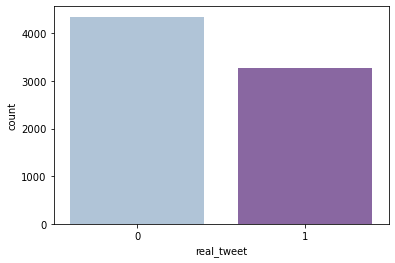

In [10]:
#Let's look at the feature classes 0 and 1
#https://www.geeksforgeeks.org/seaborn-color-palette/
#https://seaborn.pydata.org/generated/seaborn.countplot.html

real_tweets = train[train['real_tweet'] ==1]['text']
fake_tweets = train[train['real_tweet'] ==0]['text']

ax = sns.countplot(x="real_tweet", data=train, palette="BuPu")


The feature class 0 is at 6 and feature class 1 is at 4.  Their ratio is approximately 6:4 and can be considered fairly balanced.

Let's explore sample of 5 from each real_tweets and fake_tweets.

In [11]:
random_real_tweets = real_tweets.sample(5).values
random_fake_tweets = fake_tweets.sample(5).values


print('Real Tweets:\n')
for i, tweet in enumerate(random_real_tweets):
    print('[{0}] {1}\n'.format(i+1, tweet))
    if i == 5:
        break

print('-'*90)
print('Fake Tweets:\n')
for i, tweet in enumerate(random_fake_tweets):
    print('[{0}] {1}\n'.format(i+1, tweet))
    if i == 5:
        break

Real Tweets:

[1] I'm loving this classic barn shot! We may or may not have got electrocuted got stung a few times and stepped in... http://t.co/X6aSGRjsWC

[2] CHICAGO FD
STILL &amp; BOX ALARM/EMS PLAN I 
 61ST &amp; CALUMET FOR THE EL TRAIN DERAILMENT
CINS/TG

[3] #forbes #europe China's Stock Market Crash: Are There Gems In The Rubble? http://t.co/C0SlAbBP7j

[4] @HopefulBatgirl went down I was beaten and blown up. Then next thing I know Ra Al Ghul brought me back to life and I escaped and for a---

[5] California been shaking...catching on fire....and overcharging ppl on rent for the past 150+ years it ain't going nowhere.

------------------------------------------------------------------------------------------
Fake Tweets:

[1] Winter Desolation of Death is also on Tumblr:  http://t.co/93DM6gnWwC  Al Necro's reviews interviews &amp; more!

[2] @DorisMatsui thank you for supporting the President. The #IranDeal takes nuclear weapons out of the hands of Iran and keeps everyone safe

As the code was done for random sampling- if executed a number of times, it will yield a different set of samples each time.

From exploring the random sampling a few times, let's explore futher the following:
1. Which have longer text length characters
2. Which has more numbers within text 
3. Which has more punctuations
4. Which contains the most http links within text
5. Which contais the most hashtags within text

It seems that real tweets have more hashtags and contain more http links over fake tweets. 
Let's find out if this will be a true statement.

The dataset has a limited number of features. I want to create new features and explore how they affect the target feature.

Let's count our text and get some statistical data on the text.

In [12]:
#create text count feature
train['count_text'] = train['text'].apply(len)
test['count_text'] = test['text'].apply(len)

# https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.DataFrameGroupBy.describe.html
train.groupby(['real_tweet'])['count_text'].describe().T

real_tweet,0,1
count,4342.000000,3271.000000
mean,95.706817,108.113421
std,35.885924,29.309854
min,7.000000,14.000000
25%,68.000000,88.000000
50%,101.000000,115.000000
75%,130.000000,136.000000
max,157.000000,151.000000



Which has longer text length characters? Real tweets or Fake tweets

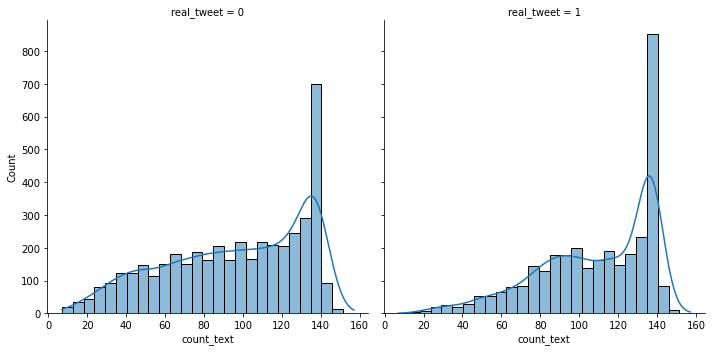

In [13]:
# Let's plot to see if real tweets or fake tweets have more text characters.

sns.displot(data=train, x="count_text", col="real_tweet", kde=True)

It looks like real tweets on average have more text characters than fake tweets.
Let's visualize this further.

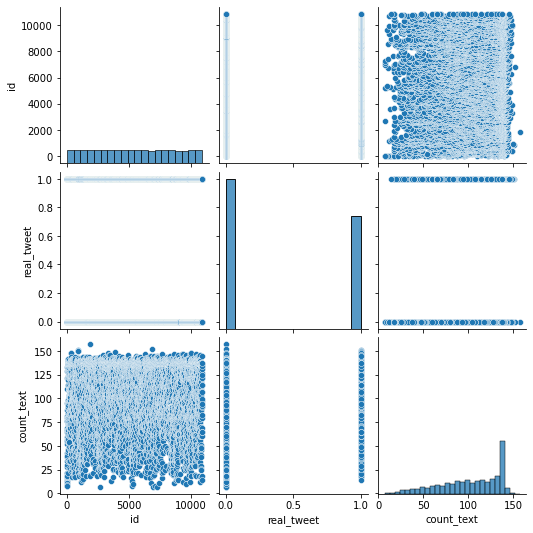

In [14]:
sns.pairplot(train)

Let's explore a boxplot

<AxesSubplot:xlabel='count_text', ylabel='real_tweet'>

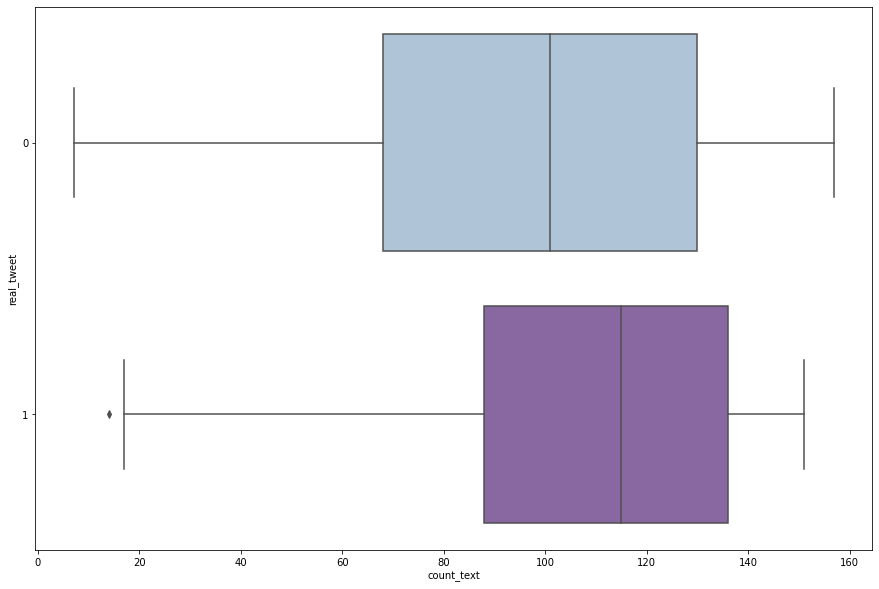

In [15]:
plt.figure(figsize=(15,10))
sns.boxplot(data=train, x='count_text', y='real_tweet', orient='h', palette='BuPu')

We will create 4 features to explore the check and count:

    1. check_digits: may not show relationship with target feature
    2. count_digits: will be set to count numbers as example 14 as 1 and 4, which can result in an error in estimate of the actual numbers in the tweet text
    3. check_punctuation : may not show relationship with target feature
    4. count_punctuation : should be highly correlated with count_text


The boxplot helps visualize that real tweets do tend to have more text characters.

Let's explore Which has more numbers within text and more punctuations.

In [20]:
#https://stackoverflow.com/questions/19859282/check-if-a-string-contains-a-number
def check_digits(text):
    if [char for char in text if char in string.digits]:
        return 1
    else:
        return 0
    
def check_punctation(text):
    if [char for char in text if char in string.punctuation]:
        return 1
    else:
        return 0
    
def count_punctation(text):
    count = 0
    for char in text:
        if char in string.punctuation:    
            count +=1
    return count

def count_digits(text):
    count = 0
    for char in text:
        if char in string.digits:    
            count +=1
    return count

In [21]:
# https://towardsdatascience.com/apply-and-lambda-usage-in-pandas-b13a1ea037f7)))
train['check_digits'] = train['text'].apply(lambda x: check_digits(x))
train['check_punctation'] = train['text'].apply(lambda x: check_punctation(x))
train['count_punctation'] = train['text'].apply(lambda x: count_punctation(x))
train['count_digits'] = train['text'].apply(lambda x: count_digits(x))


test['check_digits'] = test['text'].apply(lambda x: check_digits(x))
test['check_punctation'] = test['text'].apply(lambda x: check_punctation(x))
test['count_punctation'] = test['text'].apply(lambda x: count_punctation(x))
test['count_digits'] = test['text'].apply(lambda x: count_digits(x))


In [22]:
train.groupby(['real_tweet'])['count_punctation'].describe().T

real_tweet,0,1
count,4342.000000,3271.000000
mean,6.309074,7.543565
std,4.830297,4.195437
min,0.000000,0.000000
25%,3.000000,5.000000
50%,6.000000,7.000000
75%,9.000000,10.000000
max,61.000000,27.000000


In [23]:
# exploring count_digits by mean and not sum
train.groupby(['real_tweet'])['count_digits'].mean()

real_tweet
0    1.590511
1    2.637420
Name: count_digits, dtype: float64

<AxesSubplot:xlabel='count_punctation', ylabel='real_tweet'>

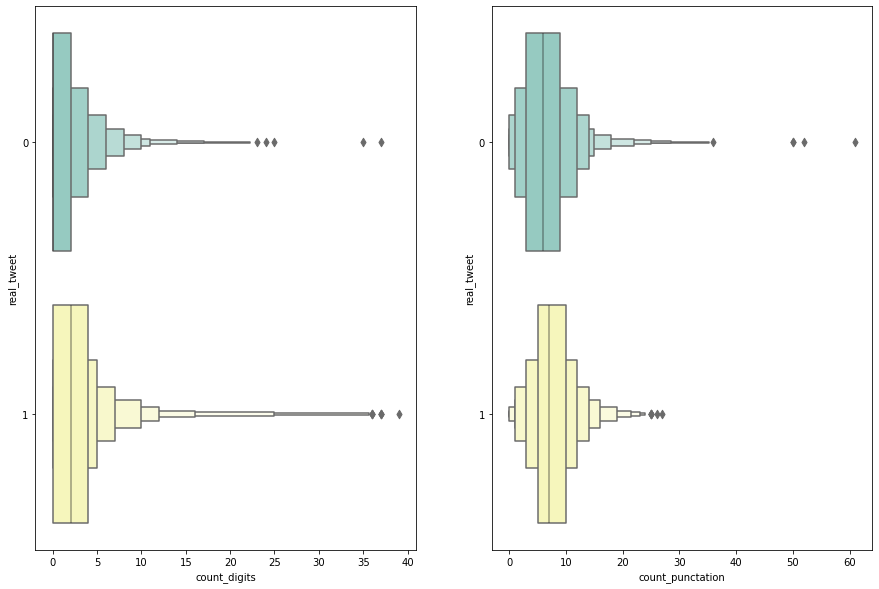

In [25]:
#plotting count_punctuation and count_digits
# https://seaborn.pydata.org/generated/seaborn.boxenplot.html
fig, ax =plt.subplots(1,2, figsize=(15,10))
sns.boxenplot(data=train, x='count_digits', y='real_tweet', orient='h', ax=ax[0], palette='Set3')
sns.boxenplot(data=train, x='count_punctation', y='real_tweet', orient='h', ax=ax[1], palette='Set3')

<AxesSubplot:xlabel='check_punctation', ylabel='count'>

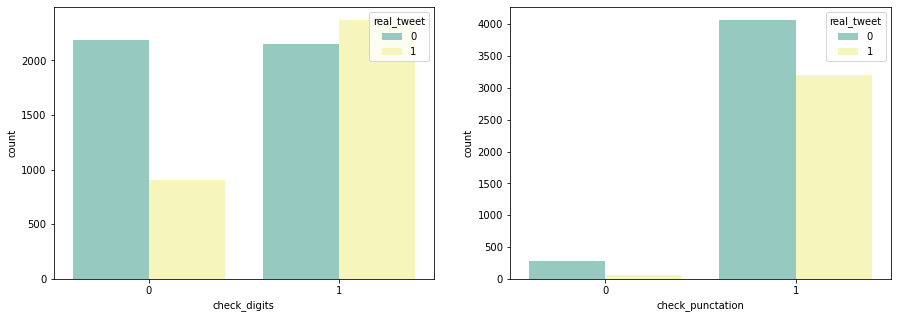

In [27]:
fig, ax =plt.subplots(1,2, figsize=(15,5))
sns.countplot(data=train, x='check_digits', hue='real_tweet', ax=ax[0], palette='Set3')
sns.countplot(data=train, x='check_punctation', hue='real_tweet', ax=ax[1], palette='Set3')

Based on the above, I gathered:

 1. check_digits: could be an important feature
 2. count_digits: the mean for fake tweets is 2 and for real tweets is 3
 3. check_punctuation: does not show a relationship with the target feature
 4. count_punctuation: does not show a relationship with the target feature

Which contains the most http links and most hashtags within text?

In [28]:
train['check_http'] = train['text'].str.contains('http')
train['check_hashtag'] = train['text'].str.contains('#')

test['check_http'] = test['text'].str.contains('http')
test['check_hashtag'] = test['text'].str.contains('#')

<AxesSubplot:xlabel='check_hashtag', ylabel='count'>

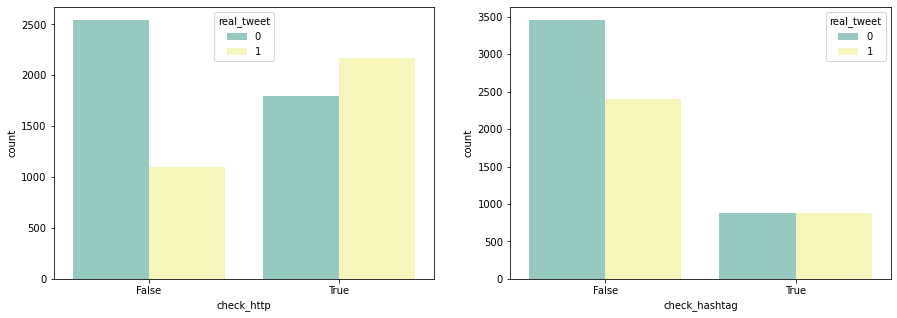

In [29]:
fig, ax =plt.subplots(1,2, figsize=(15,5))
sns.countplot(data=train, x='check_http', hue='real_tweet', ax=ax[0], palette='Set3' )
sns.countplot(data=train, x='check_hashtag', hue='real_tweet', ax=ax[1], palette='Set3')

From the above countplot we can see that check_http has a relation to our target attribute.
We also see that check_hashtag has a ratio of 1:1, and earlier the target feature had a ratio of 6:4, I will assume that check_hashtag could be an important feature.

Let's look at our data and do some needed cleaning

In [30]:
train.head()

,id,keyword,location,text,real_tweet,count_text,check_digits,check_punctation,count_punctation,count_digits,check_http,check_hashtag
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,0,1,1,0,False,True
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,0,1,1,0,False,False
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,0,1,3,0,False,False
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,1,1,2,5,False,True
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,0,1,2,0,False,True


I can see I have some data cleaning to do.

In [31]:
# Let's remove stop words https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
def clean_text(text):
    
    stop_words = stopwords.words('english')
    stop_words.append('i\'m') # I saw this abbreviation, but it is not in the list of stop-words, so I added it manually
    
    text = text.lower()
    text = ' '.join([char for char in text.split() if char not in stop_words])
    
    text = ' '.join(['' if 'http' in char else char for char in text.split()])
    
    text = ''.join([char+' ' if char in string.punctuation else char for char in text ])
    
    text = ''.join([char for char in text if char in string.ascii_lowercase or char in ' ' or  char in string.digits])
    
    text = ' '.join(text.split())
    
    return text

In [32]:
check_text_real_tweets = train[train['real_tweet']==1]['text'].head(5)
check_text_fake_tweets = train[train['real_tweet']==0]['text'].head(5)

Let's run to compare  before using clean_text and after.

In [35]:
for i, text in enumerate(check_text_real_tweets):
    print(f'Clean [{i+1}]:', clean_text(text), end='\n\n')
    print(f'Real [{i+1}]:', text, end='\n\n')
    print()

Clean [1]: deeds reason earthquake may allah forgive us

Real [1]: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all


Clean [2]: forest fire near la ronge sask canada

Real [2]: Forest fire near La Ronge Sask. Canada


Clean [3]: residents asked shelter place notified officers evacuation shelter place orders expected

Real [3]: All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected


Clean [4]: 13 000 people receive wildfires evacuation orders california

Real [4]: 13,000 people receive #wildfires evacuation orders in California 


Clean [5]: got sent photo ruby alaska smoke wildfires pours school

Real [5]: Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 




In [36]:
for i, text in enumerate(check_text_fake_tweets):
    print(f'Clean [{i+1}]:', clean_text(text), end='\n\n')
    print(f'Real [{i+1}]:', text, end='\n\n')
    print()

Clean [1]: what s man

Real [1]: What's up man?


Clean [2]: love fruits

Real [2]: I love fruits


Clean [3]: summer lovely

Real [3]: Summer is lovely


Clean [4]: car fast

Real [4]: My car is so fast


Clean [5]: goooooooaaaaaal

Real [5]: What a goooooooaaaaaal!!!!!!




In [37]:
train['clean_text'] = train['text'].apply(clean_text)
test['clean_text'] = test['text'].apply(clean_text)

In [38]:
train.head().T

,0,1,2,3,4
id,1,4,5,6,7
keyword,NaN,NaN,NaN,NaN,NaN
location,NaN,NaN,NaN,NaN,NaN
text,Our Deeds are the Reason of this #earthquake M...,Forest fire near La Ronge Sask. Canada,All residents asked to 'shelter in place' are ...,"13,000 people receive #wildfires evacuation or...",Just got sent this photo from Ruby #Alaska as ...
real_tweet,1,1,1,1,1
count_text,69,38,133,65,88
check_digits,0,0,0,1,0
check_punctation,1,1,1,1,1
count_punctation,1,1,3,2,2
count_digits,0,0,0,5,0


In [39]:
# look at how many null values in total for keyword
train['keyword'].isnull().sum()

61

There are 61 keyword missing values. Since there aren't many- I think filling our NaN values with Empty won't affect our target feature.

In [40]:
train['keyword'] = train['keyword'].fillna('Empty')
test['keyword'] = test['keyword'].fillna('Empty')

train['keyword'].unique()

array(['Empty', 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 

In [41]:
train['keyword'].nunique()

222

In [42]:
train[train['real_tweet'] == 1]['keyword'].value_counts()

Empty          42
wreckage       39
outbreak       39
derailment     39
typhoon        37
               ..
electrocute     1
epicentre       1
body%20bags     1
body%20bag      1
blazing         1
Name: keyword, Length: 221, dtype: int64

<AxesSubplot:xlabel='count', ylabel='keyword'>

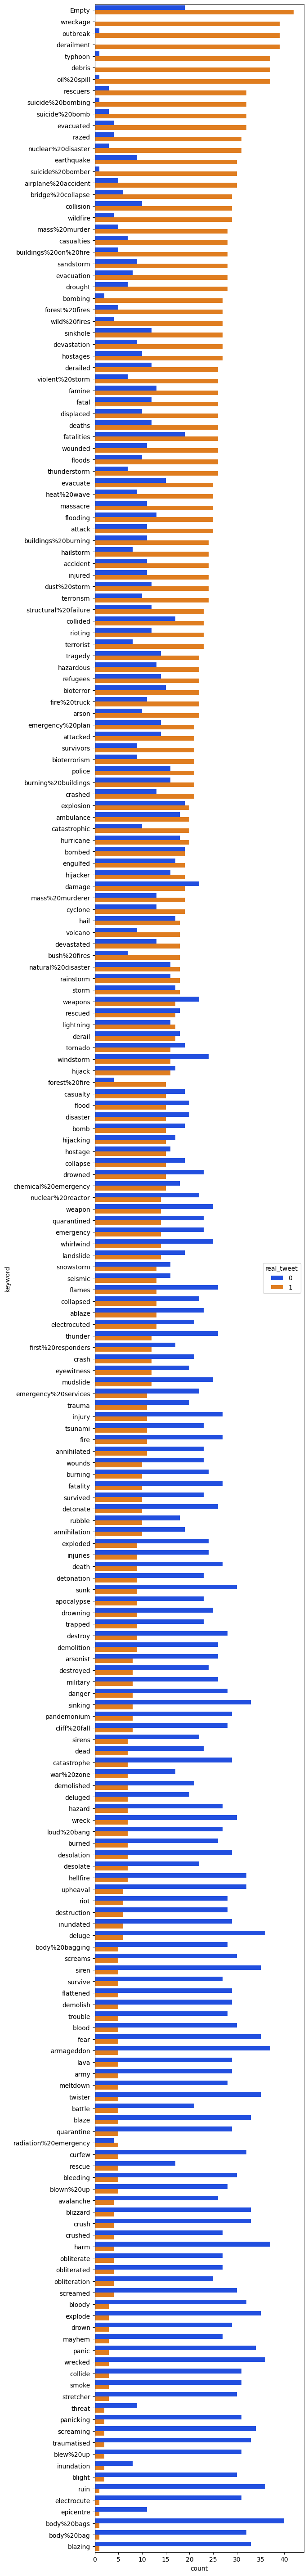

In [43]:
plt.figure(figsize=(6,75), dpi=100)
sns.countplot(data=train, y='keyword', hue='real_tweet',
              order=train[train['real_tweet'] == 1]['keyword'].value_counts().index,
             palette='bright')

Our countplot visually demonstrates how keyword values impact our target feature.

Let's now look at location.

In [44]:
train['location'].isnull().sum()

2533

In [45]:
print("missing values :", round(train['location'].isnull().sum()/train.shape[0],3),'%')

missing values : 0.333 %


We are missing a lot of location data.  Let's explore closer to see what we should do with it.

In [46]:
train['location'].nunique()

3341

In [47]:
top_location = train['location'].value_counts(normalize=True).head(50).index

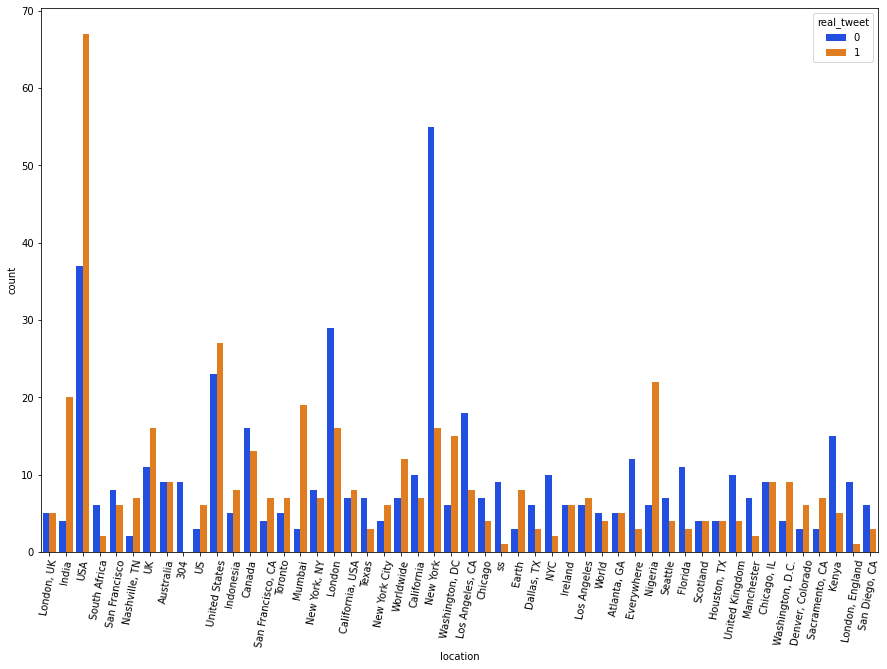

In [48]:
plt.figure(figsize=(15,10))
sns.countplot(data=train[train['location'].isin(top_location)], x='location', hue='real_tweet', palette='bright')
plt.xticks(rotation=80);

We can see the most location data is for USA and for UK.
As the location data is highly variable, I will not be using it.

I will be removing:
1. count_digits
2. count_punctuation
3. id
4. location
5. text

In [49]:
# removing count_digits, count_punctuation, id, location and text
clean_train = train.drop(['count_digits','count_punctation','id','location', 'text'], axis=1)
clean_test  = test.drop(['count_digits','count_punctation','id','location', 'text'], axis=1)

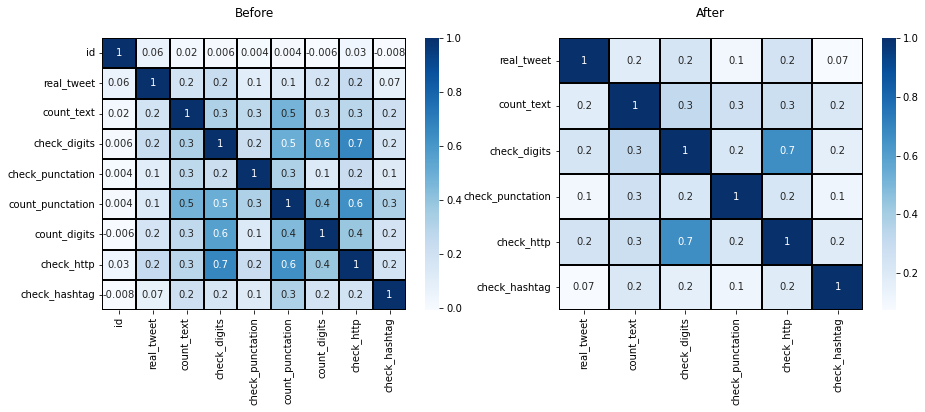

In [50]:
# https://python-graph-gallery.com/92-control-color-in-seaborn-heatmaps
fig, ax =plt.subplots(1,2, figsize=(15,5))
ax[0].title.set_text('Before\n')
sns.heatmap(train.corr(), annot=True, ax=ax[0], fmt='.1g', cmap='Blues', linewidths=2, linecolor='black')
ax[1].title.set_text('After\n')
sns.heatmap(clean_train.corr(), annot=True, ax=ax[1], fmt='.1g', cmap='Blues', linewidths=2, linecolor='black');

Pre-processing and Training Data Development


In [51]:
clean_train.head()

,keyword,real_tweet,count_text,check_digits,check_punctation,check_http,check_hashtag,clean_text
0,Empty,1,69,0,1,False,True,deeds reason earthquake may allah forgive us
1,Empty,1,38,0,1,False,False,forest fire near la ronge sask canada
2,Empty,1,133,0,1,False,False,residents asked shelter place notified officer...
3,Empty,1,65,1,1,False,True,13 000 people receive wildfires evacuation ord...
4,Empty,1,88,0,1,False,True,got sent photo ruby alaska smoke wildfires pou...


In [52]:
clean_train['check_http'] = clean_train['check_http'].apply(lambda x: 1 if x else 0)
clean_train['check_hashtag'] = clean_train['check_hashtag'].apply(lambda x: 1 if x else 0)

clean_test['check_http'] = clean_test['check_http'].apply(lambda x: 1 if x else 0)
clean_test['check_hashtag'] = clean_test['check_hashtag'].apply(lambda x: 1 if x else 0)

Applying MinMaxScaler() to standardize count_text

I used MinMax standardization to get the values [0:1].
I will use Naive Bayes, which requires only positive values.

In [53]:
scaler = MinMaxScaler()
scaler.fit(clean_train['count_text'].values.reshape(-1,1))
clean_train['count_text'] = scaler.transform(clean_train['count_text'].values.reshape(-1,1))
clean_test['count_text'] = scaler.transform(clean_test['count_text'].values.reshape(-1,1))

Next, I will apply tokenization and lemmatization.

In [54]:
#Tokenize
clean_train['clean_text'] = clean_train['clean_text'].apply(lambda x: nltk.tokenize.word_tokenize(x))
clean_test['clean_text'] = clean_test['clean_text'].apply(lambda x: nltk.tokenize.word_tokenize(x))

print('Before: ', train['clean_text'][1])
print('After: ', clean_train['clean_text'][1])

Before:  forest fire near la ronge sask canada
After:  ['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada']


In [55]:
#Lemmatize
def lem_word(text):
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text]
    return text

In [56]:
clean_train['clean_text'] = clean_train['clean_text'].apply(lem_word)
clean_test['clean_text'] = clean_test['clean_text'].apply(lem_word)

print('Before: ', train['clean_text'][10])
print('After: ', clean_train['clean_text'][10])

Before:  three people died heat wave far
After:  ['three', 'people', 'died', 'heat', 'wave', 'far']


In [57]:
clean_train = clean_train.sample(frac=1).reset_index(drop=True)

In [58]:
X_train = clean_train.drop(['real_tweet'], axis=1)
y_train = clean_train['real_tweet']
X_test = clean_test.copy()

In [59]:
print('Train shape: ', X_train.shape[0])
print('\nTest shape: ', X_test.shape[0])
print('-'*30)
print('Train y: \n\n', y_train.value_counts(), sep='')

Train shape:  7613

Test shape:  3263
------------------------------
Train y: 

0    4342
1    3271
Name: real_tweet, dtype: int64


In [60]:
X_train['clean_text'] = X_train['clean_text'].apply(lambda x: ' '.join(x))
X_test['clean_text'] = X_test['clean_text'].apply(lambda x: ' '.join(x))

In [61]:
#count_vect = CountVectorizer()
tfid = TfidfVectorizer()

#X_train_tfid_keyword = count_vect.fit_transform(X_train['keyword'])
#X_val_tfid_keyword = count_vect.transform(X_val['keyword'])
#X_test_tfid_keyword = count_vect.transform(X_test['keyword'])
X_train_tfid_text = tfid.fit_transform(X_train['clean_text'])
X_test_tfid_text = tfid.transform(X_test['clean_text'])

X_train_tfid_keyword = tfid.fit_transform(X_train['keyword'])
X_test_tfid_keyword = tfid.transform(X_test['keyword'])

In [62]:
X_train_tfid = hstack([X_train_tfid_text, X_train_tfid_keyword])
X_test_tfid = hstack([X_test_tfid_text, X_test_tfid_keyword])

In [63]:
print('Text shape')
print('Train: ' ,X_train_tfid_text.shape)
print('Test: ' ,X_test_tfid_text.shape)
print('-'*25)
print('Keyword shape')
print('Train: ' ,X_train_tfid_keyword.shape)
print('Test: ' ,X_test_tfid_keyword.shape)
print('-'*25)
print('Total shape')
print('Train: ' ,X_train_tfid.shape)
print('Test: ' ,X_test_tfid.shape)

Text shape
Train:  (7613, 15702)
Test:  (3263, 15702)
-------------------------
Keyword shape
Train:  (7613, 240)
Test:  (3263, 240)
-------------------------
Total shape
Train:  (7613, 15942)
Test:  (3263, 15942)


In [64]:
# https://stackoverflow.com/questions/49470965/use-python-to-make-a-matrix-feature-matrix
def another_feature_to_csr_matrix(feature, matrix):
    new_matrix = csr_matrix(hstack([matrix, feature.values.reshape(-1,1)]))
    return new_matrix

In [66]:
for feature in X_train.loc[:,'count_text':'check_hashtag']:
    X_train_tfid = another_feature_to_csr_matrix(X_train[feature], X_train_tfid)

for feature in X_test.loc[:,'count_text':'check_hashtag']:
    X_test_tfid = another_feature_to_csr_matrix(X_test[feature], X_test_tfid)

In [67]:
print('Total shape')
print('Train: ' ,X_train_tfid.shape)
print('Test: ' ,X_test_tfid.shape)

Total shape
Train:  (7613, 15947)
Test:  (3263, 15947)


Training the Model

In [68]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

I am using cross-validation on the X_train and evaluating the f1 score of the model.

In [72]:
#https://scikit-learn.org/stable/modules/model_evaluation.html
random_state = 1

def print_metrics(estimator):
    acc = cross_val_score(estimator, X_train_tfid, y_train, cv=3, scoring='accuracy', n_jobs=-1)
    prec = cross_val_score(estimator, X_train_tfid, y_train, cv=3, scoring='precision', n_jobs=-1)
    rec = cross_val_score(estimator, X_train_tfid, y_train, cv=3, scoring='recall', n_jobs=-1)
    f1 = cross_val_score(estimator, X_train_tfid, y_train, cv=3, scoring='f1', n_jobs=-1)
    
    print(estimator,'\n--------------------------------')
    print('ACCURACY:', np.mean(acc))
    print('PRECISION:', np.mean(prec))
    print('RECALL:', np.mean(rec))
    print('\nMain metric:', '\n--------------------------------', sep='')
    print('F1:', np.mean(f1))
    print('--------------------------------\n')

def save_main_metric(estimator):
    f1 = np.mean(cross_val_score(estimator, X_train_tfid, y_train, cv=3, scoring='f1', n_jobs=-1))
    final_scores.append(f1)

    print(estimator,'\n--------------------------------')
    print('ACCURACY:', np.mean(acc))
    print('PRECISION:', np.mean(prec))
    print('RECALL:', np.mean(rec))
    print('\nMain metric:', '\n--------------------------------', sep='')
    print('F1:', np.mean(f1))
    print('--------------------------------\n')

def save_main_metric(estimator):
    f1 = np.mean(cross_val_score(estimator, X_train_tfid, y_train, cv=3, scoring='f1', n_jobs=-1))
    final_scores.append(f1)

In [73]:
#Set hyperparameters and manually set optimal

nb = MultinomialNB(fit_prior=False)

logit = LogisticRegression(C=10 ,max_iter=1000)

svc = SVC(kernel='linear')

sgd_svm = SGDClassifier(alpha=5e-4, random_state=random_state)

sgd_log = SGDClassifier(loss='log', alpha=5e-05, random_state=random_state)

In [74]:
print_metrics(nb)
print_metrics(logit)
print_metrics(svc)
print_metrics(sgd_svm)
print_metrics(sgd_log)

MultinomialNB(fit_prior=False) 
--------------------------------
ACCURACY: 0.7784054723996073
PRECISION: 0.7334195801153282
RECALL: 0.7609294281541779

Main metric:
--------------------------------
F1: 0.7468737667238496
--------------------------------

LogisticRegression(C=10, max_iter=1000) 
--------------------------------
ACCURACY: 0.7923295768981046
PRECISION: 0.7834234863012145
RECALL: 0.7141561342874843

Main metric:
--------------------------------
F1: 0.7471712419272594
--------------------------------

SVC(kernel='linear') 
--------------------------------
ACCURACY: 0.8013927624765241
PRECISION: 0.8034518010422872
RECALL: 0.7120171433216447

Main metric:
--------------------------------
F1: 0.754935893406374
--------------------------------

SGDClassifier(alpha=0.0005, random_state=1) 
--------------------------------
ACCURACY: 0.7925917850019863
PRECISION: 0.7959664928534483
RECALL: 0.6961228511283591

Main metric:
--------------------------------
F1: 0.7425071665936681
---

In [75]:
# checking save_main_metric()
final_scores = [] 
all_models = [nb, logit, svc, sgd_svm, sgd_log]
name_model = ['Multinomial NB','Logistic Regression','SVM','SGD SVM', 'SGD Logit']

for model in all_models:
    save_main_metric(model)

In [78]:
final_results_df = pd.DataFrame(final_scores, index=name_model, columns=['F1 Score'])
result_df.T

,Multinomial NB,Logistic Regression,SVM,SGD SVM,SGD Logit
F1 Score,0.746874,0.747171,0.754936,0.742507,0.750499


<AxesSubplot:ylabel='F1 Score'>

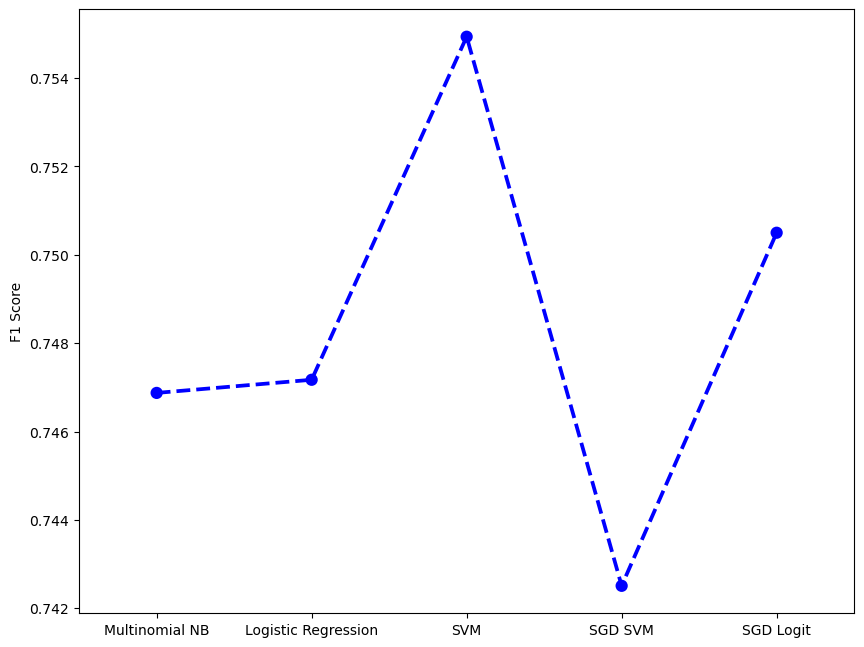

In [80]:
#plot our best result
plt.figure(figsize=(10,8), dpi=100)
sns.pointplot(y=result_df['F1 Score'] , x=result_df.index ,markers='o',linestyles='--', color='b')